## Bubble Correlations

In [1]:
import numpy as np
import math
import statistics as stat
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
from itertools import cycle
import random
from numpy import load
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import ticker
from collections import OrderedDict
import matplotlib.colors as mcolors
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d

In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [3]:
nLat = 8192
nTime = 256
nSims = 30000
nSims0 = 0
simStep = 1000
splitdata = np.arange(nSims0, nSims+1, 1000); print('splitdata ', splitdata)

nu = 2.*10**(-3)
lenLat = 8 * 0.5 * 50. / np.sqrt(2. * nu); print('lenLat = ', lenLat)
def m2eff(lamb):
    return 4. * nu * (- 1. + lamb**2)

phi_initial = np.pi
nyq = nLat//2+1; spec = nyq//16; dx = lenLat/nLat; dk = 2.*np.pi/lenLat; print('dx, dk, spec ', dx, dk, spec)
alpha = 16.; dt = dx/alpha; dtout = dt*nLat/nTime; print('dtout/dt = ', dtout/dt)
light_cone = int(dtout/dx); print('light_cone = ', light_cone)
unit_conv = nLat/nTime/alpha; print('units = ', unit_conv)
def tTime(lamb):
    return nTime - int(2/np.sqrt(m2eff(lamb))/dtout)
#tcheck = int(1/np.sqrt(m2eff)/dtout); print('tcheck =', tcheck)

splitdata  [    0  1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000
 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000
 24000 25000 26000 27000 28000 29000 30000]
lenLat =  3162.2776601683795
dx, dk, spec  0.3860202221885229 0.0019869176531592202 256
dtout/dt =  32.0
light_cone =  2
units =  2.0


### Import the Data 

In [4]:
#correlator = 
#file = thrcorr_file(2, filter_size1, list_threshold[0], list_phi0[2], list_lamb[2])
#print(file)
#np.save(file, correlator)

In [5]:
plots_file = '/home/dpirvu/big_plot_file/new_new_bubble_correlations/'
pickle_file = '/home/dpirvu/pickle_location/new_new_bubble_correlations/'

def sim_location(sim):
    return '/gpfs/dpirvu/bubble_correlations/t'+str(nTime)+'_x'+str(nLat)+'_len{:.4f}'.format(lenLat)+'_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_alph{:.4f}'.format(alpha)+'_spec'+str(spec)+'_sim'+str(sim)+'_fields.dat'
def sim_suffix(phi0, lamb):
    return '_for_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_x'+str(nLat)
def pickle_location(phi0, lamb):
    return pickle_file + 'phi0'+str(int(20*np.pi/phi0))+'_lambda'+str(int(10*lamb))+'/'
def pickle_corr_location(phi0, lamb, type):
    return pickle_file + 'th_correlator_type'+type+'_phi0'+str(int(20*np.pi/phi0))+'_lambda'+str(int(10*lamb))
def thrcorr_file(type, filter, threshold, phi0, lamb):
    return pickle_file+'thcorr_type'+str(type)+'_filter{:.4f}'.format(filter)+'_threshold'+str(threshold)+'_for_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'.npy'

def data_file_1D(data_vec, xstep, multiplier, phi0, lamb, filter, deltat):
    x = ''
    for type in data_vec:
        x += str(type) #'null_'+
    return pickle_file+'1d_type'+x+'_xstep'+str(xstep)+'_deltat'+str(deltat)+'_multiplier'+str(multiplier)+'_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_filter{:.4f}'.format(filter)+'.npy'
#    return pickle_file+'1d_type'+x+'_xstep'+str(xstep)+'_deltat'+str(deltat)+'_multiplier'+str(multiplier)+'_filter{:.4f}'.format(filter)+'.npy'
#    return pickle_file+'1d_type'+x+'_xstep'+str(xstep)+'_multiplier'+str(multiplier)+'_filter{:.4f}'.format(filter)+'.npy'
def data_file_2D(type, xstep, tstep, phi0, lamb, filter):
    return pickle_file+'2d_type'+str(type)+'_xstep'+str(xstep)+'_tstep'+str(tstep)+'_for_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_filter{:.4f}'.format(filter)+'.npy'
#    return pickle_file+'2d_type'+str(type)+'_xstep'+str(xstep)+'_for_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_filter{:.4f}'.format(filter)+'.npy'

def young_data_file_1D(data_vec, xstep, multiplier, phi0, lamb, filter, deltat):
    x = ''
    for type in data_vec:
        x += str(type) #'null_'+
    return pickle_file+'young_bubbles_1d_type'+x+'_xstep'+str(xstep)+'_deltat'+str(deltat)+'_multiplier'+str(multiplier)+'_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_filter{:.4f}'.format(filter)+'.npy'
def young_data_file_2D(type, xstep, tstep, phi0, lamb, filter):
    return pickle_file+'young_bubbles_2d_type'+str(type)+'_xstep'+str(xstep)+'_tstep'+str(tstep)+'_for_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_filter{:.4f}'.format(filter)+'.npy'


def positive_data_file(phi0, lamb, minSim, maxSim, multiplier, filter):
    pickle = pickle_location(phi0, lamb)
    suffix = sim_suffix(phi0, lamb)
    return pickle+'positive_targets_sims'+str(minSim)+'_to'+str(maxSim-1)+'_multiplier'+str(multiplier)+'_filter{:.4f}'.format(filter)+suffix+'.npy'
def negative_data_file(phi0, lamb, minSim, maxSim, multiplier, filter):
    pickle = pickle_location(phi0, lamb)
    suffix = sim_suffix(phi0, lamb)
    return pickle+'negative_targets_sims'+str(minSim)+'_to'+str(maxSim-1)+'_multiplier'+str(multiplier)+'_filter{:.4f}'.format(filter)+suffix+'.npy'

def round_to_n(x, n):
    return x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

def import_all_data(lamb, phi0, multiplier, filter):
    postlist = np.concatenate(tuple([np.load(positive_data_file(phi0, lamb, minSim, maxSim, multiplier, filter)) for minSim, maxSim in zip(splitdata, splitdata[1:])]))
    negtlist = np.concatenate(tuple([np.load(negative_data_file(phi0, lamb, minSim, maxSim, multiplier, filter)) for minSim, maxSim in zip(splitdata, splitdata[1:])]))
    return postlist.tolist(), negtlist.tolist()

[4.658106296918165, 4.759673735059503, 4.861241173200842]


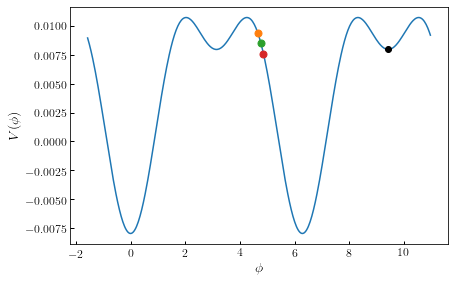

In [6]:
def V(phi, lamb=1.5):
    return ( -np.cos(phi) + 0.5 * lamb**2 * np.sin(phi)**2 ) * 4 * nu
right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x), bounds=[np.pi, 2*np.pi], method='bounded')

list_multiplier, list_threshold= [], []
list_type = ['++', '--', '++--', '+-', '-+']
thcorr = ['++', 'foo', '++--', '+-', 'foo']
list_data_plot = [0, 2, 1]
list_title_type = [r'$\xi^{++}_{bb}(t=0,r)$', r'$\xi^{+-}_{bb}(t=0,r)$', r'$\xi_{bb}(t=0,r)$']

list_phi0 = [2*np.pi/6.6, 2*np.pi/7., 2*np.pi/6.6]#[1:2]
list_lamb = [1.5, 1.5, 1.6]#[1:2]

filter_size1 = 39.39920611359256/4.
sigma01 = 0.380333

filter_size2 =  20.597556445406827
sigma02 = 0.297928

filter_size3 = 39.39920611359256
sigma03 = 0.228233

radiusBubble = filter_size3

list_multiplier, list_threshold= [], []
for multiplier in [0.2, 0.25, 0.3]:
#for multiplier in [0.1, 0.2, 0.3]:
    threshold = right_phi_at_V_max.x + np.abs(right_phi_at_V_max.x-2*phi_initial)*multiplier
    list_multiplier.append(multiplier)
    list_threshold.append(threshold)
print(list_threshold)

def Rrange(min, max, step):
    return np.arange(min, max+1, step)
def Trange(min, max, step):
    return np.arange(min, max+1, step)

fig, ax = plt.subplots(figsize=(7,4))
plt.plot([i for i in np.arange(-np.pi/2, 3.5*phi_initial, phi_initial/100)], [V(i) for i in np.arange(-np.pi/2, 3.5*phi_initial, phi_initial/100)])
[plt.plot(i, V(i), 'o', ms = 7) for i in list_threshold]
ax.tick_params(direction='in', width='1')
plt.plot(3*np.pi, V(3*np.pi), 'ko')
plt.xlabel(r'$\phi$', fontsize=14); plt.ylabel(r'$V(\phi)$', fontsize=14); plt.show()

# Plotting 

In [7]:
tableau1 = [(50, 162, 81), (172,217,141), (255,127,15), (255,185,119), (60,183,204), (152,217,228), (184,90,13), (255,217,74), (57,115,124), (134,180,169), (130,133,59), (204,201,77)]
for i in range(len(tableau1)):
    r, g, b = tableau1[i]    
    tableau1[i] = (r / 255., g / 255., b / 255.)

tableau2 = [(44,105,176), (181,200,226), (240,39,32), (255,182,176), (172,97,60), (233,195,155), (107,163,214), (181,223,253), (172,135,99), (221,201,180), (189,10,54), (244,115,122)]
for i in range(len(tableau2)):
    r, g, b = tableau2[i]    
    tableau2[i] = (r / 255., g / 255., b / 255.)

hex_list = ["dd041d","f45b69","f6e8ea","67a9cf","0a2463"][::-1]

def hex_to_rgb(value):
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_dec(value):
    return [v/256 for v in value]

def get_continuous_cmap(hlist):
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hlist]
    float_list = list(np.linspace(0,1,len(rgb_list)))
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

##### Compare Bubble Correlators

In [8]:
linestyle = ['solid', 'dashed', 'dotted']
tabl = [tableau2[0],tableau2[2],tableau1[0]]
tabl2 = [tableau2[1],tableau2[3],tableau1[1]]

def plot_comparison3(multiplier, threshold, filter, xrange, fil, deltat):
    fig = plt.figure(figsize=(12,7))
    gs = gridspec.GridSpec(3, 1, height_ratios=[2,1,1.5]) 
    ax = [[],[],[]]; ax[0] = plt.subplot(gs[0]); ax[1] = plt.subplot(gs[1], sharex = ax[0]); ax[2] = plt.subplot(gs[2], sharex = ax[1])
    plt.setp(ax[0].get_xticklabels(), visible = False); plt.setp(ax[1].get_xticklabels(), visible = False); plt.subplots_adjust(hspace=.0)

    for data in [0,1,2]:
        for phi0, lamb, zzz in zip(list_phi0, list_lamb, range(len(list_phi0))):
            xlist = xrange[:-1:]/radiusBubble
            rivolo = np.load(data_file_1D([0,1,2], xrange[-1]-xrange[-2], multiplier, phi0, lamb, filter, deltat))[data]
            rivolo[:1,0] = -1.

            markers, caps, bars = ax[list_data_plot[data]].errorbar(xlist, rivolo[:,0], yerr=rivolo[:,1], color=tabl[zzz], ms=4, ecolor=tabl[zzz], elinewidth=4, label=r'$\phi_0$ = {:.2f}'.format(phi0*np.sqrt(2))+r', $\lambda$ = '+str(lamb))

            prediction0 = np.load(thrcorr_file(data, filter, threshold, phi0, lamb))
            xaxis = np.arange(min(xrange), max(xrange)+1)[:len(prediction0)]/radiusBubble
            ax[list_data_plot[data]].plot(xaxis, prediction0, ls='-.', linewidth=2, color=tabl[zzz], alpha=0.9)

            [bar.set_alpha(0.5) for bar in bars]
            [cap.set_alpha(0.5) for cap in caps]
    handles, labels = ax[0].get_legend_handles_labels()
    handles = [h[0] for h in handles]
    [ax[i].set_xlim(0, maxpt/radiusBubble) for i in range(len(ax))]
    [ax[i].grid(alpha=0.5, linestyle='-', linewidth=0.5) for i in range(len(ax))]
    [ax[i].set(xlabel=r'$r/\bar{R}$') for i in range(len(ax))]
    [ax[i].set(ylabel=list_title_type[i]) for i in range(len(ax))]
    ax[0].legend(handles, labels, numpoints=1, title=r'$\bar{\phi}_t$'+' = {:.2f}'.format(threshold)+r', $R_0=\bar{R}/{%s}$'%(fil), fancybox=True, loc='upper right')
    plt.savefig('/home/dpirvu/compare_correlators_by_multiplier_filter'+str(int(filter))+'.pdf')
    plt.show()
    return

def plot_comparison4(phi0, lamb, filter, xrange, fil, deltat):
    for ppp in range(1):
        fig = plt.figure(figsize=(12,7))
        gs = gridspec.GridSpec(3, 1, height_ratios=[2,1,1.5]) 
        ax = [[],[],[]]; ax[0] = plt.subplot(gs[0]); ax[1] = plt.subplot(gs[1], sharex = ax[0]); ax[2] = plt.subplot(gs[2], sharex = ax[1])
        plt.setp(ax[0].get_xticklabels(), visible = False); plt.setp(ax[1].get_xticklabels(), visible = False); plt.subplots_adjust(hspace=.0)

        xlist = xrange[:-1:]/radiusBubble
        for data, j in zip([0,1,2], range(len([0,1,2]))):
            for multiplier, threshold, i in zip(list_multiplier[::], list_threshold[::], range(len(list_multiplier[::]))):
                if ppp == 0:
                    rivolo = np.load(data_file_1D([0,1,2], xrange[-1]-xrange[-2], multiplier, phi0, lamb, filter, deltat))[data]
                else:
                    rivolo = np.load(young_data_file_1D([0,1,2], xrange[-1]-xrange[-2], multiplier, phi0, lamb, filter, deltat))[data]
                rivolo[:1,0] = -1.

                if j == 0:
                    markers, caps, bars = ax[list_data_plot[data]].errorbar(xlist, rivolo[:,0], yerr=rivolo[:,1], color=tabl[j], linestyle=linestyle[i], ms=4, ecolor=tabl[j], elinewidth=4, label=r'$\bar{\phi}_t$'+' = {:.2f}'.format(threshold))
                else:
                    markers, caps, bars = ax[list_data_plot[data]].errorbar(xlist, rivolo[:,0], yerr=rivolo[:,1], color=tabl[j], linestyle=linestyle[i], ms=4, ecolor=tabl[j], elinewidth=4)

                [bar.set_alpha(0.5) for bar in bars]
                [cap.set_alpha(0.5) for cap in caps]
        handles, labels = ax[0].get_legend_handles_labels()
        handles = [h[0] for h in handles]
        [ax[i].set_xlim(0, maxpt/radiusBubble) for i in range(len(ax))]
        [ax[i].grid(alpha=0.5, linestyle='-', linewidth=0.5) for i in range(len(ax))]
        [ax[i].set(xlabel=r'$r/\bar{R}$') for i in range(len(ax))]
        ax[0].legend(handles, labels, numpoints=1,  title=r'$\phi_0$ = {:.2f}'.format(phi0*np.sqrt(2))+r', $\lambda$ = '+str(lamb)+(r', $R_0=\bar{R}/{%s}$'%(fil) if fil != 1 else r', $R_0=\bar{R}$'), fancybox=True)#, loc='upper right')
        [ax[i].set(ylabel=list_title_type[i]) for i in range(len(ax))]
        plt.savefig('/home/dpirvu/compare_correlators_by_params_filter'+str(int(filter))+'.pdf')
        plt.show()
    return

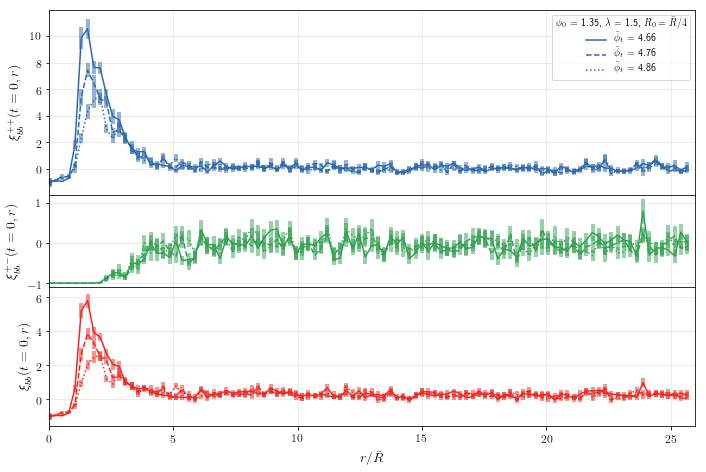

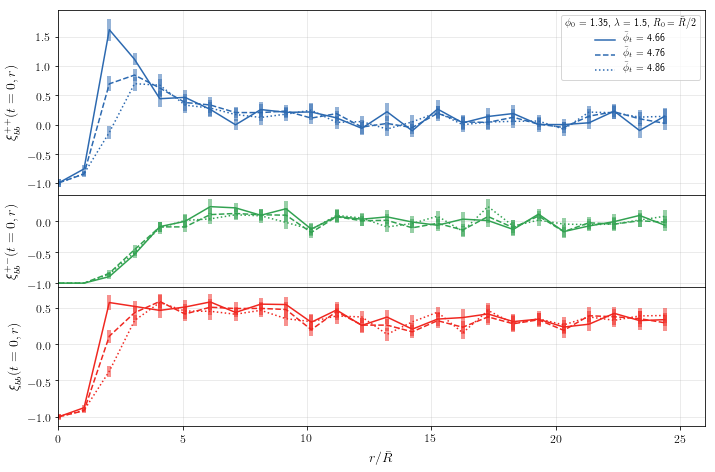

In [25]:
xmin = 1
xmax = nLat//8
Tmin = 0
Tmax = 3

deltat = np.abs(Tmin-Tmax)
maxpt = nLat//8
ftlfl = 0.1

for xstep, smoothing in zip([10, 40, 40][:2:], [filter_size1, filter_size2, filter_size3][:2:]):
    xrange = Rrange(xmin, xmax, xstep)
    for phi0, lamb in zip(list_phi0[:1:], list_lamb[:1:]):
        plot_comparison4(phi0, lamb, smoothing, xrange, (1 if smoothing==filter_size3 else 2 if smoothing==filter_size2 else 4), deltat)

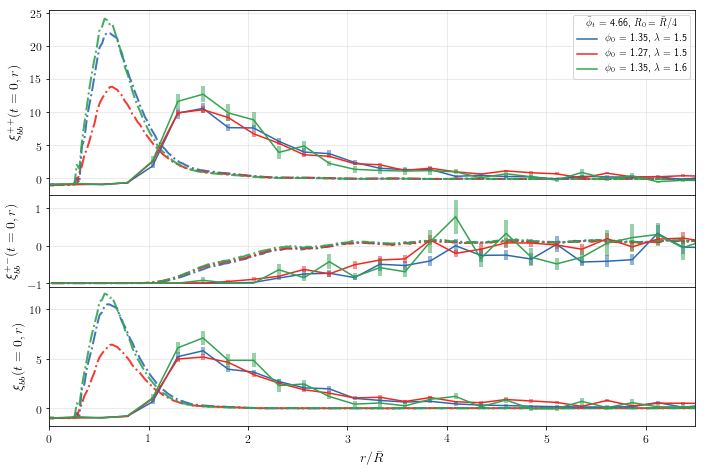

In [27]:
xmin = 1
xmax = nLat//8
Tmin = 0
Tmax = 3

deltat = np.abs(Tmin-Tmax)
maxpt = nLat//32
ftlfl = 0.01

for xstep, smoothing in zip([10, 20, 40][:1:], [filter_size1, filter_size2, filter_size3][:1:]):
    xrange = Rrange(xmin, xmax, xstep)
    for multiplier, threshold in zip(list_multiplier[:1:], list_threshold[:1:]):
        plot_comparison3(multiplier, threshold, smoothing, xrange, (2 if smoothing==filter_size2 else 4), deltat)

NameError: name 'a' is not defined

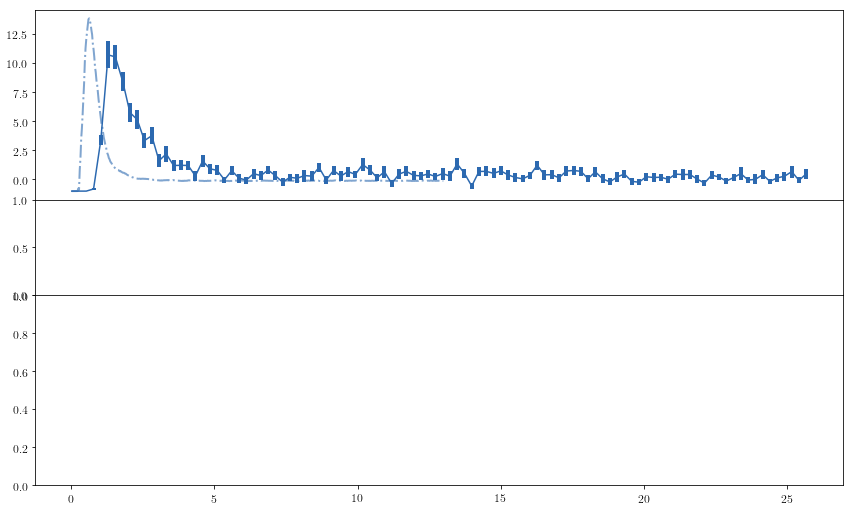

In [32]:
xmin = 1
xmax = nLat//8
Tmin = 0
Tmax = 1

deltat = np.abs(Tmin-Tmax)
maxpt = nLat//16
ftlfl = 0.01
fil = 4

multiplier, threshold = list_multiplier[0], list_threshold[0]

xstep = 10
filter = filter_size1
xrange = Rrange(xmin, xmax, xstep)

fig = plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(3, 1, height_ratios=[2,1,2]) 
ax = [[],[],[]]; ax[0] = plt.subplot(gs[0]); ax[1] = plt.subplot(gs[1], sharex = ax[0]); ax[2] = plt.subplot(gs[2], sharex = ax[1])
plt.setp(ax[0].get_xticklabels(), visible = False); plt.setp(ax[1].get_xticklabels(), visible = False); plt.subplots_adjust(hspace=.0)

#    xlist = 0.5*(xrange[:-1]+xrange[1:])/radiusBubble
xlist = xrange[:-1:]/radiusBubble
for data in [0,1,2]:
    for phi0, lamb, zzz in zip(list_phi0[1:2], list_lamb[1:2], range(len(list_phi0[1:2]))):
        if data == 2:
            rivolo = np.load(data_file_1D([0,1,2], xrange[-1]-xrange[-2], multiplier, phi0, lamb, filter, deltat))[data]
            rivolo[:,0] = gaussian_filter1d(rivolo[:,0], sigma=ftlfl)
        else:
            rivolo = np.load(data_file_1D([0,1,2], xrange[-1]-xrange[-2], multiplier, phi0, lamb, filter, deltat))[data]
            rivolo[:3,0] = -1.
        markers, caps, bars = ax[list_data_plot[data]].errorbar(xlist, rivolo[:,0], yerr=rivolo[:,1], color=tabl[zzz], ms=4, ecolor=tabl[zzz], elinewidth=4, label=r'sims')

        prediction0 = np.load(thrcorr_file(data, filter, threshold, phi0, lamb))
        xaxis0 = np.arange(min(xrange), max(xrange)+1)[:len(prediction0)]/radiusBubble
        ax[list_data_plot[data]].plot(xaxis0, prediction0, ls='-.', linewidth=2, color=tabl[zzz], alpha=0.6, label=r'$m^2_{eff}=V^{``}(\phi_{fv})$')

        prediction1 = np.asarray([a,aaa,aa][data])[:maxpt]
        xaxis1 = np.arange(min(xrange), max(xrange)+1)[:len(prediction1)]/radiusBubble
        ax[list_data_plot[data]].plot(xaxis1, prediction1, ls=':', linewidth=2, color=tabl[zzz], alpha=0.6, label=r'$m^2_{eff}=V^{``}(\phi_{fv})+V^{````}(\phi_{fv})$')

        [bar.set_alpha(0.5) for bar in bars]
        [cap.set_alpha(0.5) for cap in caps]
#handles, labels = ax[0].get_legend_handles_labels()
#handles = [h[0] for h in handles]
[ax[i].set_xlim(0, maxpt/radiusBubble) for i in range(len(ax))]
[ax[i].grid(alpha=0.5, linestyle='-', linewidth=0.5) for i in range(len(ax))]
[ax[i].set(xlabel=r'$r/\bar{R}$') for i in range(len(ax))]
[ax[i].set(ylabel=list_title_type[i]) for i in range(len(ax))]
#ax[0].legend(handles, labels, numpoints=1, title=r'$\bar{\phi}_t$ = {:.2f}'.format(threshold)+r', $R_0=\bar{R}/{%s}$'%(fil), fancybox=True, loc='upper right')
ax[0].legend(fontsize=12,title=r'$\phi_0$ = {:.2f}'.format(phi0*np.sqrt(2))+r', $\lambda$ = '+str(lamb)+', $\bar{\phi}_t$'+' = {:.2f}'.format(threshold)+r', $R_0=\bar{R}/{%s}$'%(fil), fancybox=True, loc='upper right')
plt.savefig('/home/dpirvu/compare_correlators_by_multiplier_filter'+str(int(filter))+'.pdf')
plt.show()

In [36]:
def plot_2d_corr(allmults, allthresh, xrange, trange, filter):
    for ppp in range(1):
        for multiplier, threshold in zip(allmults, allthresh):
            valmin, valmax = -1., -1.
            fig = plt.figure(figsize=(5*len(list_phi0), 5))
            grid = ImageGrid(fig, 111, nrows_ncols=(1, len(list_phi0)), share_all=True, axes_pad=0.1, cbar_location="right", cbar_mode="single")
            im = [[]]*len(list_phi0)
            for phi0, lamb, i in zip(list_phi0, list_lamb, range(len(list_phi0))):
                if ppp == 0:
                    matrix = np.load(data_file_2D(0, xstep, tstep, phi0, lamb, smoothing))
                else:
                    matrix = np.load(young_data_file_2D(0, xstep, tstep, phi0, lamb, smoothing))                
                matrix = matrix[list_multiplier.index(multiplier)]
    #            print(matrix.shape)
                MMout = '{'
                for ww, row in enumerate(matrix):
                    MMout += '{'
                    for qq, column in enumerate(row):
                        if qq != len(row)-1:
                            MMout += '{:.5f}, '.format(column)
                        else:
                            MMout += '{:.5f}'.format(column)
                    if ww != len(matrix)-1:
                        MMout += '},'
                    else:
                        MMout += '}}'
#                print(MMout)
                x = np.linspace(xrange[0], xrange[-1], len(matrix[0]))/radiusBubble
                y = np.sqrt(4*nu)*dtout*np.linspace(trange[0], trange[-1], len(matrix))
                X, Y = np.meshgrid(x, y)
                f = lambda X, Y: matrix
                Z = f(X,Y)
                im[i] = grid[i].contourf(X, Y, Z, cmap='viridis', zorder=-20)
                if np.amin(matrix) < valmin: valmin = np.amin(matrix)
                if np.amax(matrix) > valmax: valmax, maxable = np.amax(matrix), i
                grid[i].set_title(r'$\phi_0$ = {:.2f}'.format(phi0*np.sqrt(2))+r', $\lambda$ = '+str(lamb))
            grid[0].set(ylabel=r'$\phi_0^{-1} \sqrt{V_0} \; t$')
            cbar = grid[i].cax.colorbar(im[maxable]); grid[i].cax.toggle_label(True); grid[i].cax.set_title(list_title_type[0])
            [im[i].set_clim(vmin=valmin, vmax=valmax) for i in range(len(grid))]
            [grid[i].set_rasterization_zorder(-10) for i in range(len(grid))]
            [grid[i].set_aspect(6/8) for i in range(len(grid))]
            [grid[i].set_xlim(0,6) for i in range(len(grid))]
            [grid[i].set_ylim(-4,4) for i in range(len(grid))]
            [grid[i].tick_params(direction='in', which='both', top=True, right=True) for i in range(len(grid))]
            [grid[i].set(xlabel=r'$r/\bar{R}$') for i in range(len(grid))]
            plt.tight_layout(pad=2)
            fig.savefig('/home/dpirvu/correlator2D_type1'+'_filter'+str(int(filter))+'_xstep'+str(int(xrange[1]-xrange[0]))+'_tstep'+str(int(trange[1]-trange[0]))+'.pdf')
            plt.show()
    return

def plot_2d_corr2(allphi0s, alllambs, xrange, trange, filter):
    for ppp in range(1):
        for phi0, lamb in zip(allphi0s, alllambs):
            if ppp == 0:
                matrix_vec = np.load(data_file_2D(0, xstep, tstep, phi0, lamb, smoothing))
            else:
                matrix_vec = np.load(young_data_file_2D(0, xstep, tstep, phi0, lamb, smoothing))
            print(r'$\phi_0$ = {:.2f}'.format(phi0*np.sqrt(2))+r', $\lambda$ = '+str(lamb))
            valmin, valmax = -1., -1.
            fig = plt.figure(figsize=(5*len(matrix_vec), 5))
            grid = ImageGrid(fig, 111, nrows_ncols=(1, len(matrix_vec)), share_all=True, axes_pad=0.1, cbar_location="right", cbar_mode="single")
            im = [[]]*len(matrix_vec)
            for multiplier, threshold, i in zip(list_multiplier, list_threshold, range(len(list_multiplier))):
                matrix = matrix_vec[i]
                x = np.linspace(xrange[0], xrange[-1], len(matrix[0]))/radiusBubble
                y = np.sqrt(4*nu)*dtout*np.linspace(trange[0], trange[-1], len(matrix))
    #            y = dtout*np.linspace(trange[0], trange[-1], len(matrix))/(dx*radiusBubble)
                X, Y = np.meshgrid(x, y)
                f = lambda X, Y: matrix
                Z = f(X,Y)
                im[i] = grid[i].contourf(X, Y, Z, cmap='viridis', zorder=-20)
                if np.amin(matrix) < valmin: valmin = np.amin(matrix)
                if np.amax(matrix) > valmax: valmax, maxable = np.amax(matrix), i
                grid[i].set_title(r'$\bar{\phi}_t$'+' = {:.2f}'.format(threshold))
            grid[0].set(ylabel=r'$\phi_0^{-1} \sqrt{V_0} \; t$')
            cbar = grid[i].cax.colorbar(im[maxable]); grid[i].cax.toggle_label(True); grid[i].cax.set_title(list_title_type[0])
            [im[i].set_clim(vmin=valmin, vmax=valmax) for i in range(len(grid))]
            [grid[i].set_rasterization_zorder(-10) for i in range(len(grid))]
            [grid[i].set_aspect(10/10) for i in range(len(grid))]
            [grid[i].set_xlim(7) for i in range(len(grid))]
            [grid[i].tick_params(direction='in', which='both', top=True, right=True) for i in range(len(grid))]
            [grid[i].set(xlabel=r'$r/\bar{R}$') for i in range(len(grid))]
            plt.tight_layout(pad=2)
            fig.savefig('/home/dpirvu/correlator2D_type2'+'_filter'+str(int(filter))+'_xstep'+str(int(xrange[1]-xrange[0]))+'_tstep'+str(int(trange[1]-trange[0]))+'.pdf')
            plt.show()
    return

In [37]:
#xmax = 512
#xmin = 1
#xstep = 5
#xrange = Rrange(xmin, xmax, xstep)

#smoothing = filter_size1

#tmax = 31
#tmin = -30
#tstep = 2
#trange = Trange(tmin, tmax, tstep)

[-70 -67 -64 -61 -58 -55 -52 -49 -46 -43 -40 -37 -34 -31 -28 -25 -22 -19
 -16 -13 -10  -7  -4  -1   2   5   8  11  14  17  20  23  26  29  32  35
  38  41  44  47  50  53  56  59  62  65  68  71]


/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


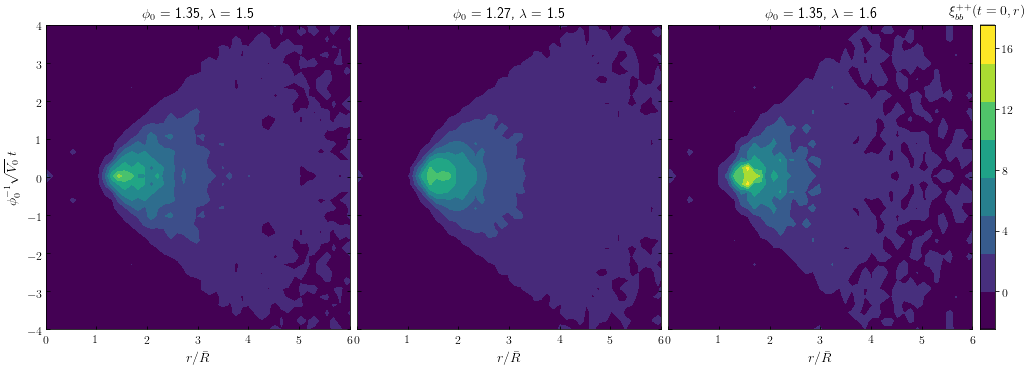

In [38]:
xmax = 400
xmin = 1
tmax = 71
tmin = -70
tstep = 3
trange = Trange(tmin, tmax, tstep); print(trange)

for xstep, smoothing in zip([5, 10][:1], [filter_size1, filter_size2][:1]):
    xrange = Rrange(xmin, xmax, xstep)
    plot_2d_corr(list_multiplier[:1], list_threshold[:1], xrange, trange, smoothing)
#    plot_2d_corr2(list_phi0[:1], list_lamb[:1], xrange, trange, smoothing)

### Change in bubble number  

In [39]:
ld1 = [0.,0.0493174/4.,0.0493174/2.,0.0493174,0.0772173,0.108921,0.148032,0.199092,0.267223,0.354941,0.460132,0.579073,0.70764,0.839889,0.970904,1.09801,1.21799,1.32733,1.42395,1.50801,1.58027,1.64119,1.69154,1.73262,1.76573,1.79171,1.81168,1.82646,1.83661,1.8428,1.84548,1.84507,1.8421,1.83693,1.82986,1.82143,1.81171,1.80079,1.78886,1.77599,1.76231,1.74793,1.73296,1.71754,1.7018,1.68583,1.66977,1.6537,1.63772,1.62196,1.60647,1.5913,1.57651,1.56207,1.548,1.53431,1.52093,1.50791,1.49517,1.48268,1.47043,1.45833,1.44631,1.43441,1.42275,1.41133,1.40021,1.38943,1.37894,1.36869,1.35863]
ld2 = [0.,0.0500916/4.,0.0500916/2.,0.0500916,0.0810806,0.115231,0.155803,0.207978,0.277569,0.367443,0.475377,0.597407,0.729191,0.864517,0.99837,1.12816,1.25072,1.3625,1.46152,1.54803,1.62282,1.68629,1.73918,1.78269,1.81797,1.84566,1.86676,1.88206,1.89227,1.89834,1.90098,1.90075,1.89823,1.89372,1.88736,1.87963,1.87052,1.8602,1.84892,1.83683,1.82413,1.81097,1.79747,1.78376,1.76992,1.75602,1.74217,1.72833,1.71453,1.70077,1.68701,1.67327,1.65959,1.646,1.63258,1.61939,1.60643,1.59379,1.58146,1.56941,1.55763,1.54603,1.53454,1.52319,1.51206,1.50113,1.49043,1.47997,1.46971,1.45965,1.44976]
ld3 = [0.,0.0561441/4.,0.0561441/2.,0.0561441,0.0890264,0.126708,0.172886,0.232821,0.312115,0.412979,0.53221,0.664804,0.805513,0.947378,1.08478,1.21472,1.33394,1.43921,1.52923,1.60503,1.66802,1.71903,1.75906,1.78967,1.81237,1.8281,1.83799,1.84274,1.84283,1.83896,1.83171,1.82172,1.80975,1.79626,1.78154,1.76612,1.74994,1.73309,1.7158,1.69819,1.68047,1.66281,1.64528,1.62797,1.61088,1.59401,1.57742,1.56113,1.54517,1.52956,1.5142,1.49901,1.48389,1.46872,1.4535,1.43821,1.42291,1.40778,1.39297,1.37864,1.36492,1.35177,1.3391,1.32687,1.31507,1.3036,1.29243,1.28155,1.27091,1.2605,1.25035]


In [50]:
def plot_fractional_Nbubs(data):
    fig, ax = plt.subplots(1, 1, figsize = (6, 3))
    for jjj, densities in enumerate(np.asarray(data)):
        xaxis = dtout*np.linspace(0, 2*trange[-1], len(densities))/(dx*radiusBubble)
#        xaxis = xaxis[densities > 0]
#        densities = densities[densities > 0]
        plt.plot(xaxis, densities, color=tableau1[::2][jjj], ls='-', label=r'$\phi_0$ = {:.2f}'.format(list_phi0[jjj]*np.sqrt(2))+r', $\lambda$ = '+str(list_lamb[jjj]))
    plt.xlabel(r'$\tau / \bar{R}$')
    plt.ylabel(r'$\frac{N(\tau)}{N_{0}(\tau)}$')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.8, linestyle='dashed', linewidth=0.5)
    plt.savefig('/home/dpirvu/fractional_change_in_N.pdf')
    return

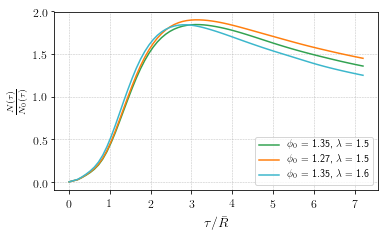

In [51]:
#plot_fractional_Nbubs([list_densities1, list_densities2, list_densities3])
plot_fractional_Nbubs([ld1, ld2, ld3])